<a href="https://colab.research.google.com/github/invegat/DS-Unit-2-Sprint-1-Linear-Algebra/blob/master/module3-dimensionality-reduction/High_Dimensional_Data_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vertical Line Test

## 1.1 Create two graphs, one that passes the vertical line test and one that does not.

In [2]:
!pip install -U matplotlib

    100% |████████████████████████████████| 12.9MB 2.6MB/s 
    100% |████████████████████████████████| 952kB 21.3MB/s 
yellowbrick 0.9 has requirement matplotlib<3.0,>=1.5.1, but you'll have matplotlib 3.0.2 which is incompatible.
  Found existing installation: matplotlib 2.1.2
    Uninstalling matplotlib-2.1.2:
      Successfully uninstalled matplotlib-2.1.2


In [1]:
%matplotlib inline
import matplotlib
matplotlib.__version__

'3.0.2'

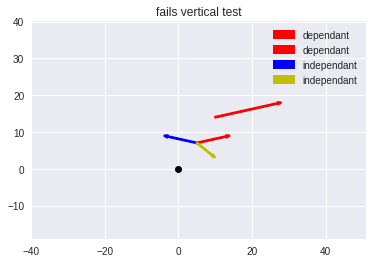

In [2]:
import numpy as np
import matplotlib.pyplot as plt
base = np.matrix('5 7; 9 2') 
M = np.array([base, base * 2, np.matrix('5 7;-9 2'), np.matrix('5 7;5 -4')])

lines = M.shape[0]

ax = plt.gca()

colors = ['r', 'r', 'b', 'y']
widths = [2,2,2,2]
arrows = []
for a,c,w in zip(M,colors,widths):
    arrow = ax.arrow(a[0,0], a[0,1], a[1,0], a[1,1], color=c,
              linewidth=w, length_includes_head=True, width=0.2)
    arrows.append(arrow)
    

plt.plot(0,0,'ok') #<-- plot a black point at the origin
plt.axis('equal')  #<-- set the axes to the same scale
plt.xlim([-40,51]) #<-- set the x axis limits
plt.ylim([-60,81]) #<-- set the y axis limits
ax.legend((arrows),(['dependant','dependant', 'independant', 'independant'])) 
plt.grid(b=True, which='major') #<-- plot grid lines
plt.title('fails vertical test')
plt.show()

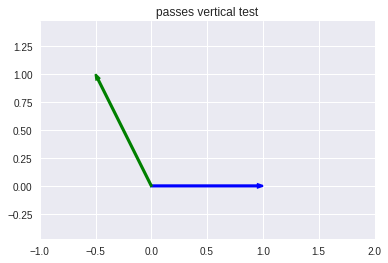

In [3]:
ax = plt.gca()
v1 = [1,0]
v2 = [-.5, 1]
ax.arrow(0, 0, v1[0], v1[1], color='b',
              linewidth=2, length_includes_head=True, width=0.01)
ax.arrow(0, 0, v2[0], v2[1], color='g',
              linewidth=2, length_includes_head=True, width=0.01)
plt.axis('equal')  #<-- set the axes to the same scale
plt.xlim([-1,2]) #<-- set the x axis limits
plt.ylim([-1,2]) #<-- set the y axis limits
plt.title('passes vertical test')
plt.show()

## 1.2 Why are graphs that don't pass the vertical line test not considered "functions?"

multiple y values for a single x value

# Functions as Relations

## 2.1 Which of the following relations are functions? Why?

\begin{align}
\text{Relation 1: } \{(1, 2), (3, 2), (1, 3)\}
\\
\text{Relation 2: } \{(1, 3), (2, 3), (6, 7)\}
\\
\text{Relation 3: } \{(9, 4), (2, 1), (9, 6)\}
\\
\text{Relation 4: } \{(6, 2), (8, 3), (6, 4)\}
\\
\text{Relation 5: } \{(2, 6), (2, 7), (2, 4)\}
\end{align}

Relation 2 only, all the others have different y values for the same x value

# Functions as a mapping between dimensions


## 3.1 for the following functions what is the dimensionality of the domain (input) and codomain (range/output)?

\begin{align}
m(𝑥_1,𝑥_2,𝑥_3)=(x_1+x_2, x_1+x_3, x_2+x_3)
\\
n(𝑥_1,𝑥_2,𝑥_3,𝑥_4)=(x_2^2 + x_3, x_2x_4)
\end{align}

3/3 for first equation 4/2 for second equation

## 3.2 Do you think it's possible to create a function that maps from a lower dimensional space to a higher dimensional space? If so, provide an example.

f(x) = (x, x*x)

# Vector Transformations

## 4.1 Plug the corresponding unit vectors into each function. Use the output vectors to create a transformation matrix.

\begin{align}
p(\begin{bmatrix}x_1 \\ x_2 \end{bmatrix}) = \begin{bmatrix} x_1 + 3x_2 \\2 x_2 - x_1 \\  \end{bmatrix}
\\
\\
q(\begin{bmatrix}x_1 \\ x_2 \\ x_3\end{bmatrix}) = \begin{bmatrix} 4x_1 + x_2 + 2x_3 \\2 x_2 - x_1 + 3x_3 \\ 5x_1 - 2x_3 + x_2  \end{bmatrix}
\end{align}

In [0]:
p = np.matrix([[1,-1],[3,2]])
q = np.matrix('4 -1 5;1 2 1;2 3 -2')

## 4.2 Verify that your transformation matrices are correct by choosing an input matrix and calculating the result both via the traditional functions above and also via vector-matrix multiplication.

In [5]:
import numpy as np
px = np.matrix([2,5])
py_t = [2 + 3 * 5,2*5 - 2]
py_v = px * p
print(f'{py_t}\n{np.array(py_v)[0]}')
qx = np.matrix('20 50 40')
qy_t = [4*20 + 50 + 2*40 ,2*50 - 20 + 3 * 40,5*20 - 2*40 + 50]
# x = [4*20 + 50 + 2*40 ,-20 + 2*50 + 3 * 40,5*20 + 50 - 2*40]
qy_v = qx * q
print(f'qt_t{qy_t}\nqy_v{qy_v}')

[17, 8]
[17  8]
qt_t[210, 200, 70]
qy_v[[210 200  70]]


# Eigenvalues and Eigenvectors

## 5.1 In your own words, give an explanation for the intuition behind eigenvalues and eigenvectors.

An eigenvector is a vector that dosn't change slope as x is changed, an eigenvalue is the scaling of the eighenvector as x is changed

# The Curse of Dimensionality

## 6.1 What are some of the challenges of working with high dimensional spaces?

need to reduce dimensions for effective visualizations, finding out what columns are important and independant are removing useless noise and dependant columns, massive amounts of data, underfitting and overfitting

## 6.2 What is the rule of thumb for how many observations you should have compared to parameters in your model?

5 times as many observations as columns

# Principal Component Analysis

## 7.1 Load the UCI Machine Learning Repository's [Iris Dataset](https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv) and use PCA to isolate the dataset's first and second principal components and plot them on a graph. 

In [8]:
import pandas as pd
url = 'https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv'
df = pd.read_csv(url)
us = df.species.unique().tolist()
print(us)
df.species = df.species.apply(lambda s: us.index(s))
df.tail()

['setosa', 'versicolor', 'virginica']


,sepal_length,sepal_width,petal_length,petal_width,species
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sxdf = df.drop('species',inplace=False,axis=1)
std = scaler.fit_transform(sxdf)

In [11]:
from sklearn.decomposition import PCA
pca = PCA(2)
B = pca.fit_transform(std)
# print("\n Eigenvectors: \n", pca.components_)
# print("\n Eigenvalues: \n",pca.explained_variance_)
# print("\n Projected Data: \n", B)
# plt.scatter(np.linspace(0,1, len(pca.components_[0])),pca.components_[0],c='g')
# plt.scatter(np.linspace(0,1, len(pca.components_[1])),pca.components_[1],c='b');
pdf = pd.DataFrame(data = B, columns = ['Principle Component 1', 'Principle Component 2'])
pdf['species'] = df['species'].apply(lambda s: us[s])
pdf.tail()

,Principle Component 1,Principle Component 2,species
145,1.870522,0.382822,virginica
146,1.558492,-0.905314,virginica
147,1.520845,0.266795,virginica
148,1.376391,1.016362,virginica
149,0.959299,-0.022284,virginica


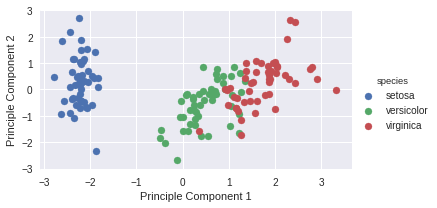

In [12]:
import seaborn
fg = seaborn.FacetGrid(data=pdf, hue='species', hue_order=us, aspect=1.71)
fg.map(plt.scatter, 'Principle Component 1', 'Principle Component 2').add_legend();

# Stretch Goal

## 1) Do NOT work on the stretch goal until you feel like you have a firm grasp of eigenvectors, eigenvalues, and PCA. Prioritize self-study over the stretch goal if you are not comfortable with those topics yet.

## 2) Explore further the intuition behind eigenvalues and eigenvectors by creating your very own eigenfaces:

<center>![Eigenfaces](https://i.pinimg.com/236x/1c/f1/01/1cf101a9859437a5d096a04b05be06b4--faces-tattoo.jpg)</center>

You don't necessarily have to use this resource, but this will get you started: 
[Eigenface Tutorial](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/)